## Load the dataset

In [ ]:
+from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Datasets/Twitter_Data.csv.zip"

Archive:  /content/gdrive/MyDrive/Datasets/Twitter_Data.csv.zip
  inflating: Twitter_Data.csv        


In [ ]:
!unzip "/content/gdrive/MyDrive/Datasets/Reddit_Data.csv.zip"

Archive:  /content/gdrive/MyDrive/Datasets/Reddit_Data.csv.zip
  inflating: Reddit_Data.csv         


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Data Extraction & Cleaning

In [ ]:
reddit_data = pd.read_csv('Reddit_Data.csv')
twitter_data = pd.read_csv('Twitter_Data.csv')

In [ ]:
def cleanText(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    cleanedText = ' '.join(''.join([i for i in string if not i.isdigit()]).split())
    
    for i in punc:
        cleanedText = cleanedText.replace(i, '')
        
    a = [i for i in cleanedText if i.isalpha() or i == ' ']
            
    final_text = ' '.join(''.join(a).split())
    return final_text

***Cleaning Data***

In [ ]:
reddit_data = reddit_data.dropna(how='any')
twitter_data = twitter_data.dropna(how='any')

In [ ]:
reddit_data.rename(columns={'clean_comment':'comment'}, inplace=True)
twitter_data.rename(columns={'clean_text':'comment'}, inplace=True)

reddit_data.category = reddit_data.category.apply(lambda x: int(x))
twitter_data.category = twitter_data.category.apply(lambda x: int(x))

reddit_data.comment = reddit_data.comment.apply(cleanText)
twitter_data.comment = twitter_data.comment.apply(cleanText)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
reddit_data.drop_duplicates(subset='comment', keep=False, inplace=True)
twitter_data.drop_duplicates(subset='comment', keep=False, inplace=True)

In [ ]:
# Concat reddit data and twiter data
concat_df = pd.concat([reddit_data, twitter_data], ignore_index=True)
concat_df.drop_duplicates(subset='comment', keep=False, inplace=True)

##Data Visualization

***Compare Total Comments From both Platforms***

In [ ]:
counts = [len(reddit_data), len(twitter_data), len(concat_df)]
labels = ['Reddit', 'Twitter', 'Total']
colors = ['#ff4500', '#1DA1F2', '#50C878']

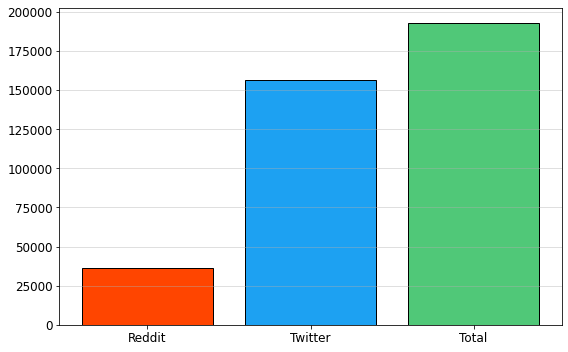

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

***Count The Negative, Neutral, and Positive Comments***

In [ ]:
negative_count = [len(reddit_data[reddit_data.category == -1]),
                 len(twitter_data[twitter_data.category == -1]),
                 len(concat_df[concat_df.category == -1])]

neutral_count = [len(reddit_data[reddit_data.category == 0]),
                 len(twitter_data[twitter_data.category == 0]),
                 len(concat_df[concat_df.category == 0])]

positive_count = [len(reddit_data[reddit_data.category == 1]),
                 len(twitter_data[twitter_data.category == 1]),
                 len(concat_df[concat_df.category == 1])]

x = ['Reddit', 'Twitter', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

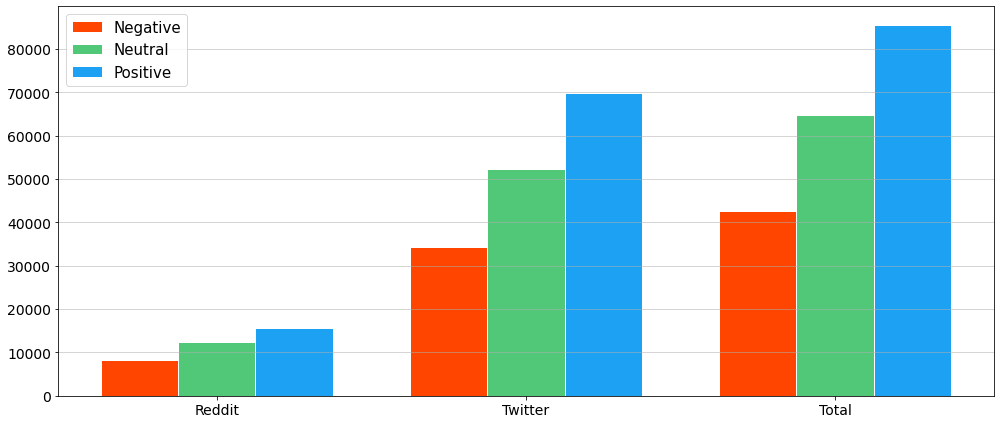

In [ ]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

***Count the Average Length of All the 3 Sentiments Comment***

In [ ]:
negative_avg = int(sum([len(i) for i in concat_df[concat_df.category == -1].comment]) / len(concat_df[concat_df.category == 1]))
neutral_avg = int(sum([len(i) for i in concat_df[concat_df.category == 0].comment]) / len(concat_df[concat_df.category == 0]))
positive_avg = int(sum([len(i) for i in concat_df[concat_df.category == 1].comment]) / len(concat_df[concat_df.category == 1]))

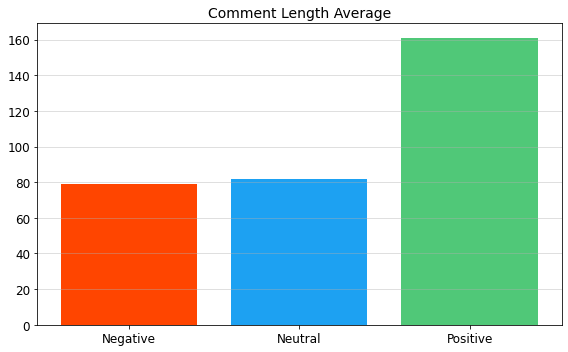

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg], color=colors)

plt.title('Comment Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

***Create Word Clouds to See Which Words Appear Frequently***

In [ ]:
negative_words = ''
neutral_words = ''
positive_words = ''

stopwords = set(STOPWORDS)

for comment, category in zip(concat_df.comment, concat_df.category):
    tokens = comment.split()
    
    for word in tokens:
        if category == -1:
            negative_words += word + ' '
        elif category == 0:
            neutral_words += word + ' '
        else:
            positive_words += word + ' '

In [ ]:
negative_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_words)

neutral_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neutral_words)

positive_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_words)

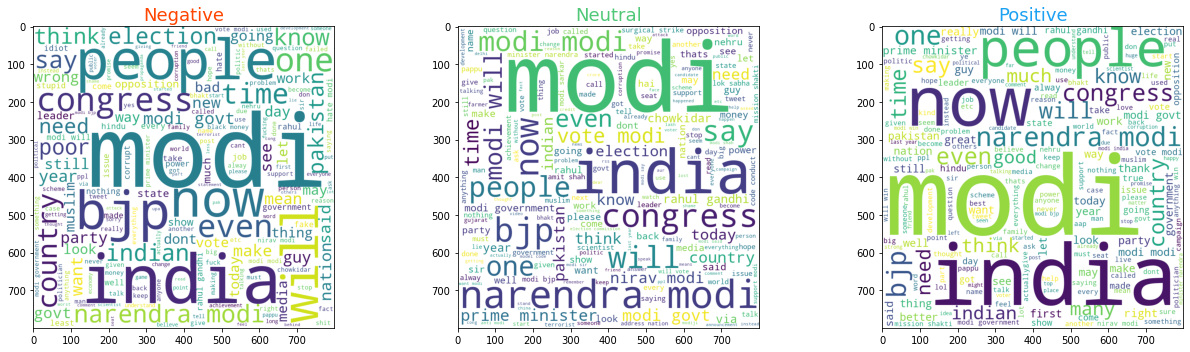

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), facecolor=None)

ax1.imshow(negative_cloud)
ax1.set_title('Negative', fontsize=18, color='#ff4500')


ax2.imshow(neutral_cloud)
ax2.set_title('Neutral', fontsize=18, color='#50C878')

ax3.imshow(positive_cloud)
ax3.set_title('Positive', fontsize=18, color='#1DA1F2')

plt.tight_layout()